In [74]:
import wandb
from wandb.keras import WandbMetricsLogger

import tensorflow as tf

from datasets import load_dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM

from tqdm import tqdm

In [2]:
use_wandb = False
batch_size = 8

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-01-02 10:01:02.506288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 10:01:02.710317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 10:01:02.710929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 10:01:02.807793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
PREFIX = "summarize: "

# Get the dataset
train_dataset = load_dataset("json", data_files="../../dataset_splits/train_0_1.jsonl")["train"]
valid_dataset = load_dataset("json", data_files="../../dataset_splits/valid_0_1.jsonl")["train"]

# Remove unwanted columns
train_dataset = train_dataset.remove_columns(['id', 'subreddit', 'title'])
valid_dataset = valid_dataset.remove_columns(['id', 'subreddit', 'title'])

Using custom data configuration default-e7aa29a4076bebb1
Found cached dataset json (/home/ayushthakur/.cache/huggingface/datasets/json/default-e7aa29a4076bebb1/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-59b00a6d247f833f
Found cached dataset json (/home/ayushthakur/.cache/huggingface/datasets/json/default-59b00a6d247f833f/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
train_dataset

Dataset({
    features: ['post', 'summary'],
    num_rows: 11672
})

In [18]:
train_dataset[0]

{'post': "So what I've gathered is if I want to do her the biggest favor I can it is to initiate utter no-contact between us. I don't agree that this will be best but for once I think I may take advice instead of having experience be my teacher.\n\nHow do I go about doing it? Do I tell her? We ended very friendly and share a dog together. She suffers from mild depression and I am very worried about what this could do to her work performance, is there any other way?\n\nWhat have been your experiences? what has worked best when your partner was very upset about the breakup but understood that it was probably best for both of you?",
 'summary': 'If no better option exists I will do NO CONTACT for her benefit. How do I go about initiating this protocol best?'}

In [44]:
# Number of words vs counts
post_counts = []
summary_counts = []

for sample in tqdm(train_dataset):
    post = sample["post"]
    summary = sample["summary"]
    
    post_counts.append(len(post.replace("\n\n", " ").split(" ")))
    summary_counts.append(len(summary.split(" ")))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11672/11672 [00:01<00:00, 9760.74it/s]


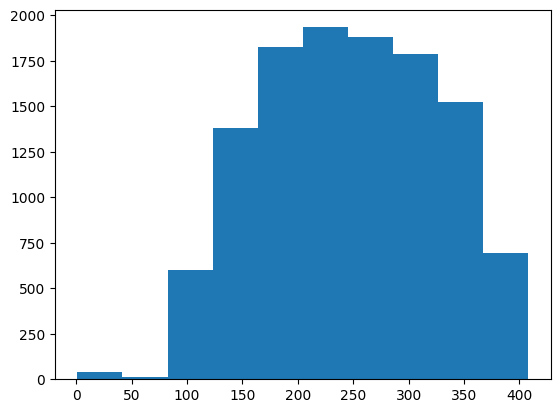

In [56]:
import numpy as np
import matplotlib.pyplot as plt

post_counts = np.array(post_counts)
summary_counts = np.array(summary_counts)

plt.hist(post_counts, bins=10);

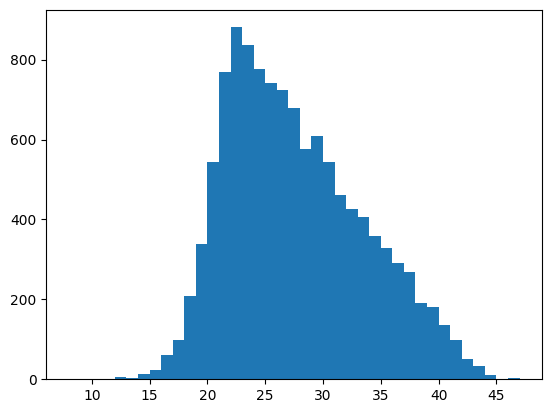

In [57]:
plt.hist(summary_counts, bins=np.arange(summary_counts.min(), summary_counts.max()+1));

In [15]:
valid_dataset

Dataset({
    features: ['post', 'summary'],
    num_rows: 644
})

In [16]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [17]:
tf.keras.backend.clear_session()
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")
model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


In [58]:
def preprocess_function(examples):
    inputs = [PREFIX + doc for doc in examples["post"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(text_target=examples["summary"], max_length=48, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [59]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3579: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

In [64]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

In [66]:
tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_valid_set = model.prepare_tf_dataset(
    valid_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [67]:
optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=2e-5, weight_decay=0.01
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [69]:
model.fit(
    x=tf_train_set,
    validation_data=tf_valid_set,
    epochs=3,
    callbacks=[]
)

Epoch 1/3
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-02 10:59:41.675789: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd8e0014460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-02 10:59:41.675867: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-01-02 10:59:42.249540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-02 10:59:44.812197: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1459/1459 [==============================] - 373s 223ms/step - loss: 3.2052 - val_loss: 2.9337
Epoch 2/3
1459/1459 [==============================] - 321s 220ms/step - loss: 3.0778 - val_loss: 2.8840
Epoch 3/3
1459/1459 [==============================] - 320s 219ms/step - loss: 3.0231 - val_loss: 2.8559


In [71]:
model.save("some_model")

INFO:tensorflow:Assets written to: some_model/assets


INFO:tensorflow:Assets written to: some_model/assets


In [91]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

In [92]:
inputs = tokenizer(text, return_tensors="tf").input_ids

In [93]:
inputs

<tf.Tensor: shape=(1, 101), dtype=int32, numpy=
array([[21603,    10,    37,    86,    89,  6105,   419,  8291,  1983,
         1364,     7,  7744,  2672,  1358,     6,   533,   124,  1358,
            6,    11,   827,  1358,     5,    94,    31,     7,     8,
          167,  8299,  1041,    30,     3, 26074,     8,  3298,  5362,
           16,   797,   892,     6,    84,    56,  5656,    95,   797,
         2765,    11,   482,   207,    18,  8832,    53,     6,  7021,
         2476,   640,     8,   684,     5,    94,    31,   195,  1364,
            8, 11724,    11,   987,     8,  6173,    18,  1123,   138,
          189,    63,    11, 11711,    12,   726,    70,  2725,   698,
            5,   275,   150,    80,   492,   365,  1514, 31471,   399,
          215,    56,   726,     3,     9, 23925,    72,    16,  5161,
            5,     1]], dtype=int32)>

In [94]:
model.save("some_model")

INFO:tensorflow:Assets written to: some_model/assets


INFO:tensorflow:Assets written to: some_model/assets


In [96]:
model.save_pretrained("some_model_new", save_model=True)

In [98]:
model_infer = TFAutoModelForSeq2SeqLM.from_pretrained("some_model_new")
model_infer.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at some_model_new.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


In [99]:
outputs = model.generate(inputs, max_new_tokens=48, do_sample=False)

In [100]:
outputs

<tf.Tensor: shape=(1, 39), dtype=int32, numpy=
array([[    0,    86,    89,  6105,   419,  8291,  1983,  1364,     7,
         7744,  2672,  1358,     6,   533,   124,  1358,     6,    11,
          827,  1358,     5,    94,    31,     7,     8,   167,  8299,
         1041,    30,     3, 26074,     8,  3298,  5362,    16,   797,
          892,     5,     1]], dtype=int32)>

In [90]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

"Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history."

In [101]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

"Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history."